In [79]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from collections import Counter
import joblib
import matplotlib.pyplot as plt
from utils.elpv_reader import load_dataset
import warnings
warnings.filterwarnings('ignore', category=metrics._classification.UndefinedMetricWarning)

In [80]:
def proportion_compute(label_set):
    label1, label2, label3, label4 = 0, 0, 0, 0
    for i in range(len(label_set)):
        if label_set[i] == 0:
            label1 += 1
        elif label_set[i] == 1:
            label2 += 1
        elif label_set[i] == 2:
            label3 += 1
        else:
            label4 += 1
    print("The percentage of the label 0 in the train set is: {:.2%}".format(label1 / len(label_set)))
    print("The percentage of the label 1 in the train set is: {:.2%}".format(label2 / len(label_set)))
    print("The percentage of the label 2 in the train set is: {:.2%}".format(label3 / len(label_set)))
    print("The percentage of the label 3 in the train set is: {:.2%}".format(label4 / len(label_set)))

### Step1:  Load the dataset

In [81]:
# Respectively: image, reflection probability, type. Our classifier needs to classify based on reflection probability
images, proba, types = load_dataset()
print(f"The size of the data set is: {images.shape[0]}")
print(f"The size of the image is: {images.shape[1]} * {images.shape[2]}")
print(proba)
print(types)

The size of the data set is: 2624
The size of the image is: 300 * 300
[1. 1. 1. ... 0. 0. 0.]
['mono' 'mono' 'mono' ... 'poly' 'poly' 'poly']


In [82]:
# change label, label will be 0 1 2 3
label_mapping = {0.0: 0, 0.3333333333333333: 1, 0.6666666666666666: 2, 1.0: 3}
for x in range(len(proba)):
    if proba[x] in label_mapping:
        proba[x] = label_mapping[proba[x]]
print(proba)

[3. 3. 3. ... 0. 0. 0.]


### Step2: Feature extraction

(2624, 256)


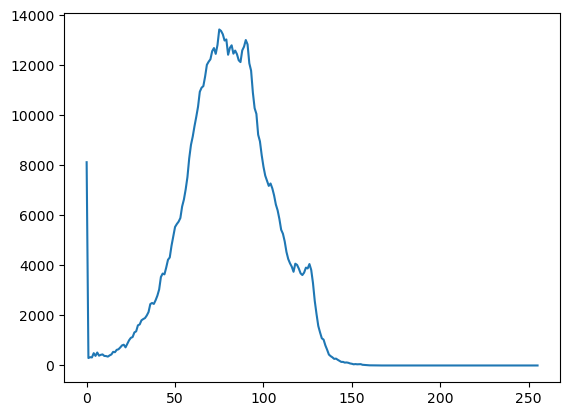

In [83]:
# Convert each image to the pixel histogram
image_his = []
for image in images:
    hist = cv2.calcHist([images], [0], None, [256], [0, 256])
    image_his.append(hist.flatten())
    
image_his = np.array(image_his)
print(image_his.shape)
plt.plot(image_his[0])
plt.show()

### Step3: Split the dataset into train set and test set

In [84]:
x_train, x_test, y_train, y_test = train_test_split(image_his, proba, test_size=0.25, stratify=proba, random_state=42)
# statistics of the proportion of each label in the training set
print("Original train set shape %s" %Counter(y_train))
proportion_compute(y_train)

Original train set shape Counter({0.0: 1131, 3.0: 536, 1.0: 221, 2.0: 80})
The percentage of the label 0 in the train set is: 57.47%
The percentage of the label 1 in the train set is: 11.23%
The percentage of the label 2 in the train set is: 4.07%
The percentage of the label 3 in the train set is: 27.24%


### Step4: Data augmentation

In [85]:
# due to the imbalance of the proportion of each type of samples in the training set, all samples were comprehensively sampled.
smt = SMOTETomek(random_state=42)
new_x_train, new_y_train = smt.fit_resample(x_train, y_train)
print("After sampling, the train set shape %s" %Counter(new_y_train))
proportion_compute(new_y_train)

After sampling, the train set shape Counter({1.0: 1131, 0.0: 1131, 3.0: 1131, 2.0: 1131})
The percentage of the label 0 in the train set is: 25.00%
The percentage of the label 1 in the train set is: 25.00%
The percentage of the label 2 in the train set is: 25.00%
The percentage of the label 3 in the train set is: 25.00%


### Step5: Use the PCA and SVM classifier to process all dataset

In [ ]:
# normalization
scaler = MinMaxScaler()
new_x_train = scaler.fit_transform(new_x_train)
x_test = scaler.fit_transform(x_test)

pipeline = Pipeline([
    ('pca', PCA()),
    ('svm', SVC())
])

param_grid = [{
    'pca__n_components': range(1, image_his.shape[1] + 1),
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear']
},
{
    'pca__n_components': range(1, image_his.shape[1] + 1),
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'svm__kernel': ['rbf']
}]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=100)
grid_search.fit(x_train, y_train.astype("str"))

In [8]:
print(f"Best params of SVM is: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
predict_labels = best_model.predict(x_test)
print(f"The performance of the best model is:")
print(metrics.classification_report(y_test, predict_labels))

# Test

In [9]:
from sklearn.metrics import confusion_matrix
import pandas as pd

### 1. Calculate the confusion matrix for all test images

In [38]:
# Calculate the confusion matrix for all test images
predict_labels = grid_search.predict(x_test)
confusion_all = confusion_matrix(y_test, predict_labels)
# print(confusion_all)
confusion_all = np.array(confusion_all)

# Class label
class_labels = ["0.0", "0.3333", "0.6666", "1.0"]

# Print confusion matrix
print("Confusion Matrix (All Test Images):")
print("\t" + "\t".join(class_labels))
for i in range(len(class_labels)):
    print(class_labels[i] + "\t", end="")
    for j in range(len(class_labels)):
        print(confusion_all[i][j], end="\t")
    print()

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_all[i][i]
    fp = sum(confusion_all[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_all[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Calculate and output the Accuracy for each class
for i in range(len(class_labels)):
    tp = confusion_all[i][i]
    tn = sum(confusion_all[j][k] for j in range(len(class_labels)) for k in range(len(class_labels)) if j != i and k != i)
    fp = sum(confusion_all[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_all[i][j] for j in range(len(class_labels)) if j != i)
    
    accuracy_class_i = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Accuracy: {accuracy_class_i:.2%}")


Confusion Matrix (All Test Images):
	0.0	0.3333	0.6666	1.0
0.0	349	3	1	24	
0.3333	67	2	0	5	
0.6666	24	0	0	2	
1.0	93	0	1	85	

Class 0.0:
Precision: 0.65
Recall: 0.93
F1 Score: 0.77

Class 0.3333:
Precision: 0.40
Recall: 0.03
F1 Score: 0.05

Class 0.6666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.73
Recall: 0.47
F1 Score: 0.58

Class 0.0:
Accuracy: 67.68%

Class 0.3333:
Accuracy: 88.57%

Class 0.6666:
Accuracy: 95.73%

Class 1.0:
Accuracy: 80.95%


### 2.Calculate the confusion matrix for monocrystalline

In [26]:
# monocrystalline_indices range of index values
y_test = y_test.astype("str")
monocrystalline_indices = np.where(types == 'mono')
print("Monocrystalline Indices Range:", min(monocrystalline_indices[0]), "to", max(monocrystalline_indices[0]))

Monocrystalline Indices Range: 0 to 2443


In [27]:
# Prints the unique value of the types array
unique_types = np.unique(types)
print(unique_types)


['mono' 'poly']


In [28]:
# calculate monocrystalline_indices
monocrystalline_indices = np.where(types == 'mono')[0]  # Extract the index array with [0]

# Create a y_test_mono array that contains only the real labels for images of type "monocrystalline"
y_test_mono = y_test[monocrystalline_indices[monocrystalline_indices < len(y_test)]]

# Creates the predict_labels_mono array that contains only prediction labels for images of type "monocrystalline"
predict_labels_mono = predict_labels[monocrystalline_indices[monocrystalline_indices < len(y_test)]]

In [29]:
# Check that the sample in the types array matches the label in the corresponding position in y_test
mismatched_indices = np.where(types != y_test)[0]
print("Indices with mismatched labels:", mismatched_indices)


Indices with mismatched labels: [0]


/var/folders/2f/yj4193f95b58g8d0ymcxp11w0000gn/T/ipykernel_60889/3185375691.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mismatched_indices = np.where(types != y_test)[0]


In [30]:
print(f"Sample at index 0 - 'types' label: {types[0]}, 'y_test' label: {y_test[0]}")

Sample at index 0 - 'types' label: mono, 'y_test' label: 0.6666666666666666


In [41]:
# Computational confusion matrix
confusion_mono = confusion_matrix(y_test_mono.astype("str"), predict_labels_mono)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box with an explained confusion matrix
confusion_mono_df = pd.DataFrame(confusion_mono, index=class_labels, columns=class_labels)

print("\nConfusion Matrix (monocrystalline):")
print(confusion_mono_df)

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_mono[i][i]
    fp = sum(confusion_mono[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_mono[i][j] for j in range(len(class_labels)) if j != i)
   
    # Check if the denominator is zero before performing the division
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Calculate and output the Accuracy for each class in monocrystalline
for i in range(len(class_labels)):
    tp = confusion_mono[i][i]
    tn = sum(confusion_mono[j][k] for j in range(len(class_labels)) for k in range(len(class_labels)) if j != i and k != i)
    fp = sum(confusion_mono[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_mono[i][j] for j in range(len(class_labels)) if j != i)
    
    accuracy_class_i = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\nClass {class_labels[i]} in monocrystalline:")
    print(f"Accuracy: {accuracy_class_i:.2%}")


Confusion Matrix (monocrystalline):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 120                   1                   0   11
0.3333333333333333   25                   2                   0    2
0.6666666666666666   11                   0                   0    1
1.0                  41                   0                   0   26

Class 0.0:
Precision: 0.61
Recall: 0.91
F1 Score: 0.73

Class 0.3333333333333333:
Precision: 0.67
Recall: 0.07
F1 Score: 0.12

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.65
Recall: 0.39
F1 Score: 0.49

Class 0.0 in monocrystalline:
Accuracy: 62.92%

Class 0.3333333333333333 in monocrystalline:
Accuracy: 88.33%

Class 0.6666666666666666 in monocrystalline:
Accuracy: 95.00%

Class 1.0 in monocrystalline:
Accuracy: 77.08%


### 3.Calculate the confusion matrix for polycrystalline

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
# Check that the types array contains labels of type 'poly'
contains_poly = 'poly' in types

if contains_poly:
    print("The types array contains labels of type 'poly'")
else:
    print("The types array does not contain labels of type 'poly'")

The types array contains labels of type 'poly'


In [35]:
# print("y_test size:", y_test.shape)

# # predict_labels size
# predict_labels = svm_classifier.predict(his_test)
# print("predict_labels size:", predict_labels.shape)

In [36]:
polycrystalline_indices = np.where(types == 'poly')[0]
print(polycrystalline_indices)

[  60   61   62 ... 2621 2622 2623]


In [42]:
y_test_poly = y_test[polycrystalline_indices[polycrystalline_indices < len(y_test)]]
predict_labels_poly = predict_labels[polycrystalline_indices[polycrystalline_indices < len(y_test)]]

# The confusion matrix of polycrystalline hybrid samples is calculated
confusion_poly = confusion_matrix(y_test_poly.astype("str"), predict_labels_poly)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box to display the confusion matrix
confusion_poly_df = pd.DataFrame(confusion_poly, index=class_labels, columns=class_labels)

# Print confusion matrix
print("Confusion Matrix (poly):")
print(confusion_poly_df)


# Calculate and output the Precision, Recall, and F1 Score for each category
for i in range(len(class_labels)):
    tp = confusion_poly[i][i]
    fp = sum(confusion_poly[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_poly[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Calculate and output the Accuracy for each class in polycrystalline
for i in range(len(class_labels)):
    tp = confusion_poly[i][i]
    tn = sum(confusion_poly[j][k] for j in range(len(class_labels)) for k in range(len(class_labels)) if j != i and k != i)
    fp = sum(confusion_poly[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_poly[i][j] for j in range(len(class_labels)) if j != i)
    
    accuracy_class_i = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\nClass {class_labels[i]} in polycrystalline:")
    print(f"Accuracy: {accuracy_class_i:.2%}")

Confusion Matrix (poly):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 229                   2                   1   13
0.3333333333333333   42                   0                   0    3
0.6666666666666666   13                   0                   0    1
1.0                  52                   0                   1   59

Class 0.0:
Precision: 0.68
Recall: 0.93
F1 Score: 0.79

Class 0.3333333333333333:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.78
Recall: 0.53
F1 Score: 0.63

Class 0.0 in polycrystalline:
Accuracy: 70.43%

Class 0.3333333333333333 in polycrystalline:
Accuracy: 88.70%

Class 0.6666666666666666 in polycrystalline:
Accuracy: 96.15%

Class 1.0 in polycrystalline:
Accuracy: 83.17%


In [48]:
# Number and index of '0.0' images successfully classified
success_0_indices = np.where((y_test.astype("str") == '0.0') & (predict_labels == '0.0'))[0]
print(f"Number of '0.0' images successfully classified: {len(success_0_indices)}")
print(f"Successfully classified '0.0' image index: {success_0_indices}")

Number of '0.0' images successfully classified: 349
Successfully classified '0.0' image index: [  1   2   4   5   9  13  19  23  26  27  28  30  31  32  36  40  41  42
  43  44  45  46  47  48  49  50  52  53  60  61  62  63  66  67  71  74
  78  79  80  81  83  85  86  87  90  92  93  94  95  96  97  98  99 101
 104 106 108 109 111 112 114 117 119 121 122 123 124 125 128 132 134 135
 139 140 141 142 145 148 149 150 151 152 153 155 156 159 160 162 164 168
 169 173 175 177 178 180 182 186 187 189 190 193 195 196 199 202 203 204
 205 206 207 209 210 212 213 214 216 217 218 219 223 224 227 229 231 232
 233 235 236 238 240 241 244 245 246 248 249 250 251 252 253 255 256 258
 259 260 261 264 266 268 269 273 275 279 280 281 282 284 286 289 290 291
 292 293 294 296 297 298 299 300 304 308 310 313 314 316 317 321 322 323
 324 325 327 328 329 331 332 335 336 337 338 341 342 344 345 347 348 349
 350 352 353 356 360 361 363 366 370 371 372 375 376 377 378 379 381 383
 384 385 386 387 390 391 392 

In [49]:
# Number and index of misclassified images
misclassified_indices = np.where(y_test.astype("str") != predict_labels)[0]
print("The number of misclassified images:", len(misclassified_indices))
print("Misclassified image index:", misclassified_indices)

The number of misclassified images: 220
Misclassified image index: [  0   3   6   8  10  11  12  14  15  16  17  20  22  25  29  33  35  37
  38  39  51  54  55  56  59  64  65  68  70  73  76  77  82  84  88  91
 102 103 107 110 115 118 120 126 129 130 133 136 143 144 154 157 158 161
 165 166 167 170 172 174 176 179 183 184 185 188 192 197 198 200 201 208
 211 215 225 226 228 234 237 239 242 243 254 257 265 270 271 276 278 285
 287 295 301 303 306 307 309 311 312 315 319 320 326 333 339 340 343 346
 351 354 357 359 364 365 367 368 373 380 382 395 396 403 405 407 409 410
 414 418 419 422 426 427 429 430 432 433 434 437 438 440 444 448 450 453
 454 460 461 462 463 465 469 470 471 476 477 479 483 484 486 487 489 492
 493 496 499 500 501 504 509 515 516 517 518 523 524 525 526 530 535 540
 545 546 547 548 550 555 561 563 564 565 568 569 570 572 575 576 580 591
 597 598 599 601 603 607 610 612 614 621 623 627 633 635 636 642 646 647
 648 652 653 654]
